# chart_plotting


> This module contains several Python functions for Machine Learning models' related plots 

In [ ]:
#| default_exp chart_plotting

In [ ]:
#| hide
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export
from __future__ import annotations
from that_ml_library.utils import *
from pathlib import Path
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve,validation_curve, RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import pandas as pd
import plotly.express as px
import dtreeviz
from sklearn.tree import export_graphviz
import graphviz
from matplotlib.cm import get_cmap
import plotly.graph_objects as go
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns

In [ ]:
from that_ml_library.data_preprocess import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

## Variance Inflation Factor

In [ ]:
#| export
def get_vif(df:pd.DataFrame, # dataframe to plot
            plot_corr=False # to plot the correlation matrix
           ):
    """
    Perform variance inflation factor calculation, and optionally plot correlation matrix
    
    Note that your dataframe should only have numerical features to perform VIF
    """
    if plot_corr:
        fig,ax = plt.subplots(figsize=(10,10))
        dataplot = sns.heatmap(np.round(df.corr(),3), cmap="YlGnBu", annot=True)  
        plt.show()

    df_const = add_constant(df)    
    vif = pd.Series([variance_inflation_factor(df_const.values, i) 
                    for i in range(df_const.shape[1])], index=df_const.columns)
    return vif

In [ ]:
show_doc(get_vif)

---

[source](https://github.com/anhquan0412/that-ml-library/blob/main/that_ml_library/chart_plotting.py#L29){target="_blank" style="float:right; font-size:smaller"}

### get_vif

>      get_vif (df:pandas.core.frame.DataFrame, plot_corr=False)

Perform variance inflation factor calculation, and optionally plot correlation matrix

Note that your dataframe should only have numerical features to perform VIF

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| df | pd.DataFrame |  | dataframe to plot |
| plot_corr | bool | False | to plot the correlation matrix |

**1. Why you should use VIF:** to detect multicollinearity (more than 2 columns)

- Compute variance inflation factor
- The VIF is variance inflation factor the ratio of the variance of βˆj when fitting the full model (with other features) divided by the variance of βˆj if fit on its own
    - Min(VIF) = 1 (no collinearity)
    - VIF >5 or >10 means high collinearity 


**2. How to calculating VIF:** Set the suspected collinearity feature (e.g. X1) as label, and try to predict X1 using a regression model and other features


**3. What to do with high collinearity:**
- Drop one of them
- Combine them to create a new feature
- Perform an analysis designed for highly correlated variables, such as principal components analysis or partial least squares regression.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/titanic.csv')
df_num = process_missing_values(df[['Survived','Pclass','Age','SibSp','Parch']],
                                missing_cols='Age',strategies='median')

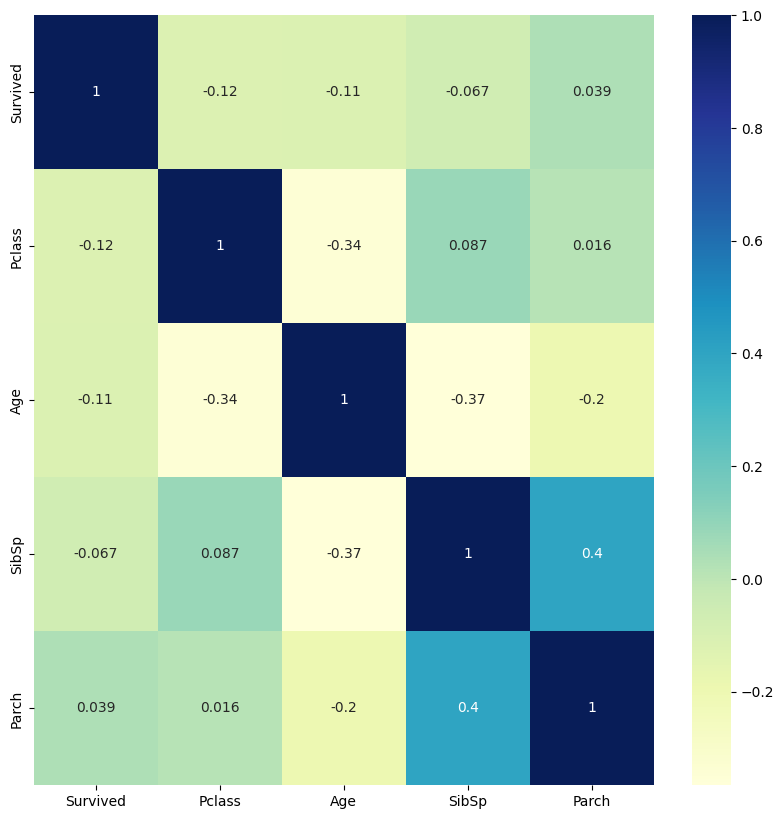

const       28.227667
Survived     1.061895
Pclass       1.173788
Age          1.361584
SibSp        1.351837
Parch        1.199945
dtype: float64

In [ ]:
get_vif(df_num,True)

## Model evaluation curves

In [ ]:
#| export
def plot_learning_curve(
    estimator, # sklearn's classifier
    title, # Title of the chart
    X, # Training features
    y, # Training label
    axes=None, # matplotlib's axes
    ylim=None, # y axis range limit
    cv=None, # sklearn's cross-validation splitting strategy
    n_jobs=-1, # Number of jobs to run in parallel
    scoring=None, # metric
    train_sizes=[0.05, 0.24, 0.43, 0.62, 0.81, 1.], # List of training size portion
    save_fig=False, # To store the chart as png in images directory
    figsize=(20,5), # Matplotlib figsize
    seed=42 # Random seed
):
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=figsize)

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        random_state=seed
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    plt.grid()
    if save_fig:
        _path = Path('./images')
        create_dir(_path)
        plt.savefig(_path/f'{title}.png')
    return plt

In [ ]:
show_doc(plot_learning_curve)

---

[source](https://github.com/anhquan0412/that-ml-library/blob/main/that_ml_library/chart_plotting.py#L48){target="_blank" style="float:right; font-size:smaller"}

### plot_learning_curve

>      plot_learning_curve (estimator, title, X, y, axes=None, ylim=None,
>                           cv=None, n_jobs=-1, scoring=None, train_sizes=[0.05,
>                           0.24, 0.43, 0.62, 0.81, 1.0], save_fig=False,
>                           figsize=(20, 5), seed=42)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| estimator |  |  | sklearn's classifier |
| title |  |  | Title of the chart |
| X |  |  | Training features |
| y |  |  | Training label |
| axes | NoneType | None | matplotlib's axes |
| ylim | NoneType | None | y axis range limit |
| cv | NoneType | None | sklearn's cross-validation splitting strategy |
| n_jobs | int | -1 | Number of jobs to run in parallel |
| scoring | NoneType | None | metric |
| train_sizes | list | [0.05, 0.24, 0.43, 0.62, 0.81, 1.0] | List of training size portion |
| save_fig | bool | False | To store the chart as png in images directory |
| figsize | tuple | (20, 5) | Matplotlib figsize |
| seed | int | 42 | Random seed |

<module 'matplotlib.pyplot' from '/home/quan/anaconda3/envs/dev/lib/python3.10/site-packages/matplotlib/pyplot.py'>

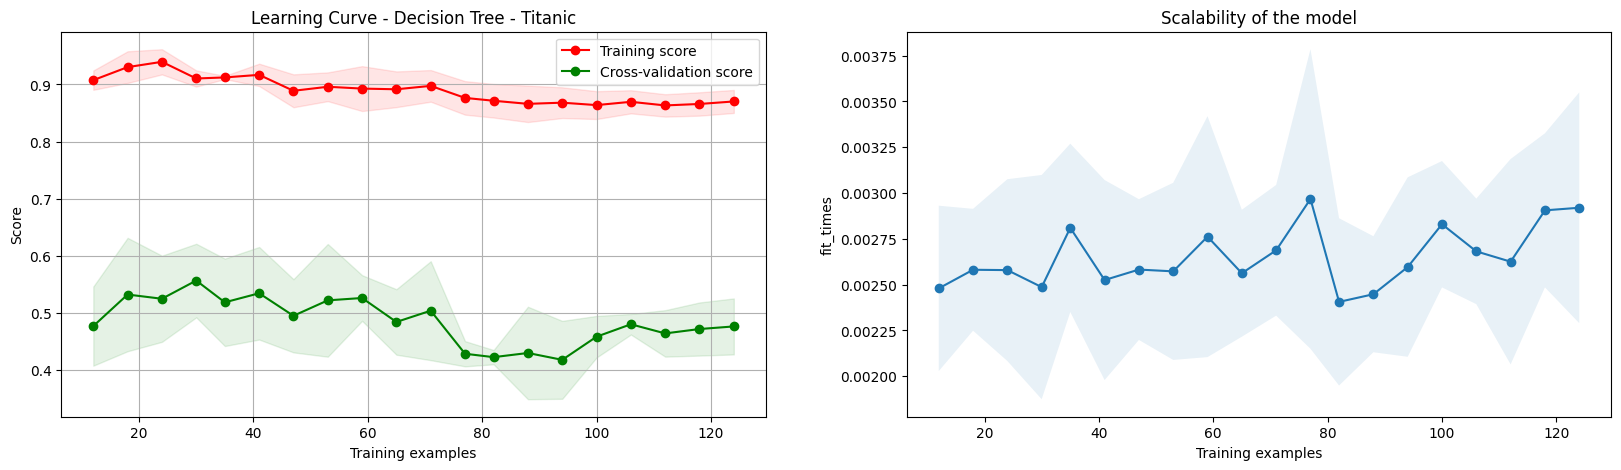

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',random_state=42,min_samples_leaf=1)
plot_learning_curve(dt,'Learning Curve - Decision Tree - Titanic',df_num.drop('Survived',axis=1),df_num['Survived'],
                      cv=5,scoring='f1_macro',train_sizes=np.linspace(0.1,1,20))

In [ ]:
#| export
def plot_validation_curve(
    estimator, # sklearn's classifier
    title, # Title of the chart
    X, # Training features
    y, # Training label
    ylim=None, # y axis range limit
    cv=None, # sklearn's cross-validation splitting strategy
    param_name=None, # Name of model's hyperparameter
    param_range=None, # List containing range of value for param_name
    is_log=False, # To log the value in param_range, for plotting
    n_jobs=-1, # Number of jobs to run in parallel
    scoring=None, # metric
    save_fig=False, # To store the chart as png in images directory    
    figsize=(8,4), # Matplotlib figsize
    fill_between=True, # To add a upper and lower one-std line for train and test curve
    enumerate_x=False # Convert categorical hyperparam to numerical, for x axis
):
    train_scores, test_scores = validation_curve(
            estimator,
            X,
            y,
            param_name=param_name,
            param_range=param_range,
            scoring=scoring,
            n_jobs=n_jobs,
            cv=cv,
            )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    if is_log:
        plt.semilogx(param_range, train_scores_mean, marker="o",label="Training score", color="r")
        plt.semilogx(param_range, test_scores_mean, marker="o",label="Cross-validation score", color="g")

    else:
        tmp = param_range
        if enumerate_x:
            tmp = np.arange(1,len(tmp)+1)
        plt.plot(tmp, train_scores_mean, "o-", color="r", label="Training score")
        plt.plot(tmp, test_scores_mean, "o-", color="g", label="Cross-validation score")

    if fill_between:
        plt.fill_between(
            param_range,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color="r",
        )
        plt.fill_between(
            param_range,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g",
        )
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid()
    plt.legend(loc="best")
    if save_fig:
        _path = Path('./images')
        create_dir(_path)
        plt.savefig(_path/f'{title}.png')
    return plt

In [ ]:
show_doc(plot_validation_curve)

---

[source](https://github.com/anhquan0412/that-ml-library/blob/main/that_ml_library/chart_plotting.py#L135){target="_blank" style="float:right; font-size:smaller"}

### plot_validation_curve

>      plot_validation_curve (estimator, title, X, y, ylim=None, cv=None,
>                             param_name=None, param_range=None, is_log=False,
>                             n_jobs=-1, scoring=None, save_fig=False,
>                             figsize=(8, 4), fill_between=True,
>                             enumerate_x=False)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| estimator |  |  | sklearn's classifier |
| title |  |  | Title of the chart |
| X |  |  | Training features |
| y |  |  | Training label |
| ylim | NoneType | None | y axis range limit |
| cv | NoneType | None | sklearn's cross-validation splitting strategy |
| param_name | NoneType | None | Name of model's hyperparameter |
| param_range | NoneType | None | List containing range of value for param_name |
| is_log | bool | False | To log the value in param_range, for plotting |
| n_jobs | int | -1 | Number of jobs to run in parallel |
| scoring | NoneType | None | metric |
| save_fig | bool | False | To store the chart as png in images directory |
| figsize | tuple | (8, 4) | Matplotlib figsize |
| fill_between | bool | True | To add a upper and lower one-std line for train and test curve |
| enumerate_x | bool | False | Convert categorical hyperparam to numerical, for x axis |

<module 'matplotlib.pyplot' from '/home/quan/anaconda3/envs/dev/lib/python3.10/site-packages/matplotlib/pyplot.py'>

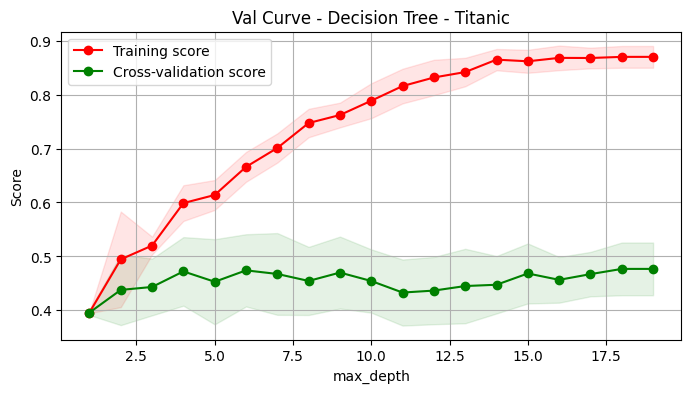

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',random_state=42)
plot_validation_curve(dt,'Val Curve - Decision Tree - Titanic',df_num.drop('Survived',axis=1),df_num['Survived'],
                      cv=5,param_range=np.arange(1,20,1),param_name='max_depth',scoring='f1_macro')

## Tree visualization

In [ ]:
#| export
def plot_tree_dtreeviz(estimator, # sklearn's classifier
                       X, # Training features
                       y, # Training label
                       target_name:str, # The (string) name of the target variable; e.g., for Titanic, it's "Survived"
                       class_names:list, # List of names associated with the labels (same order); e.g. ['no','yes']
                       tree_index=0, # Index (from 0) of tree if model is an ensemble of trees like a random forest.
                       depth_range_to_display=None, # Range of depth levels to be displayed. The range values are inclusive
                       fancy=False, # To draw fancy tree chart (as opposed to simplified one)
                       scale=1.0 # Scale of the chart. Higher means bigger
                      ):
    "Plot a decision tree using dtreeviz. Note that you need to install graphviz before using this function"
    viz = dtreeviz.model(estimator,X,y,tree_index=tree_index,target_name=target_name,
                        feature_names=X.columns.values,
                        class_names=class_names,
                        )
    
    return viz.view(depth_range_to_display=depth_range_to_display,
         orientation='LR',
         instance_orientation='LR',fancy=fancy,scale=scale)

In [ ]:
show_doc(plot_tree_dtreeviz)

---

[source](https://github.com/anhquan0412/that-ml-library/blob/main/that_ml_library/chart_plotting.py#L207){target="_blank" style="float:right; font-size:smaller"}

### plot_tree_dtreeviz

>      plot_tree_dtreeviz (estimator, X, y, target_name:str, class_names:list,
>                          tree_index=0, depth_range_to_display=None,
>                          fancy=False, scale=1.0)

Plot a decision tree using dtreeviz. Note that you need to install graphviz before using this function

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| estimator |  |  | sklearn's classifier |
| X |  |  | Training features |
| y |  |  | Training label |
| target_name | str |  | The (string) name of the target variable; e.g., for Titanic, it's "Survived" |
| class_names | list |  | List of names associated with the labels (same order); e.g. ['no','yes'] |
| tree_index | int | 0 | Index (from 0) of tree if model is an ensemble of trees like a random forest. |
| depth_range_to_display | NoneType | None | Range of depth levels to be displayed. The range values are inclusive |
| fancy | bool | False | To draw fancy tree chart (as opposed to simplified one) |
| scale | float | 1.0 | Scale of the chart. Higher means bigger |

After you have installed graphviz (https://github.com/parrt/dtreeviz#installation), uncomment these codes to run dtreeviz

/home/quan/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


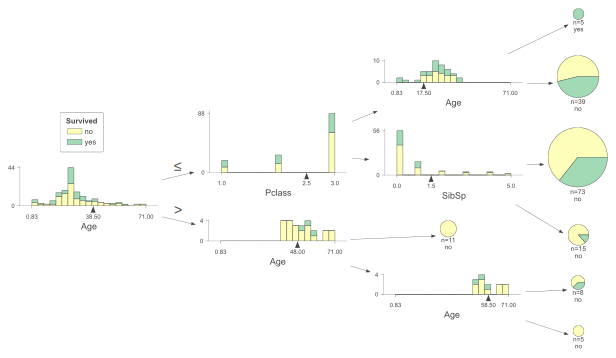

In [ ]:
# dt = DecisionTreeClassifier(criterion='entropy',random_state=42,class_weight=None,max_depth=3)
# dt.fit(df_num.drop('Survived',axis=1),df_num['Survived'])
# plot_tree_dtreeviz(dt,df_num.drop('Survived',axis=1),df_num['Survived'],
#                    target_name='Survived',
#                    class_names=['no','yes'],
#                    fancy=True,scale=1)

The result will look like this:
![](images/dtreeviz_1.png)

/home/quan/anaconda3/envs/dev/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


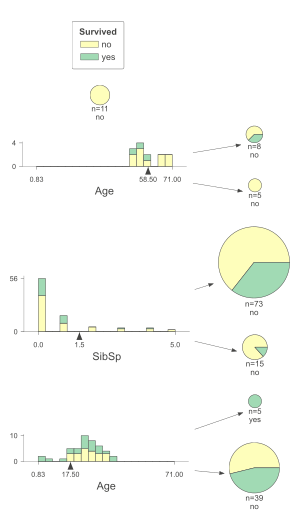

In [ ]:
# plot_tree_dtreeviz(dt,df_num.drop('Survived',axis=1),df_num['Survived'],
#                    target_name='Survived',
#                    class_names=['no','yes'],
#                    depth_range_to_display=[2,3],
#                    fancy=True,scale=1.2)

The result will look like this:
![](images/dtreeviz_2.png)

In [ ]:
#| export
def plot_tree_sklearn(estimator, # sklearn's classifier
                      feature_names, # List of names of dependent variables (features)
                      class_names:list, # List of names associated with the labels (same order); e.g. ['no','yes']
                      rotate=True, # To rotate the tree graph
                      fname='tmp' # Name of the png file to save(no extension)
                     ):
    "Plot a decision tree using sklearn. Note that this will output a png file with fname instead of showing it in the notebook"
    s = export_graphviz(estimator,out_file=None,feature_names=feature_names,filled=True,class_names=class_names,
                       special_characters=True,rotate=rotate,rounded=True)
    graph = graphviz.Source(s,format='png')
    
    _path = Path('./images')
    create_dir(_path)
    graph.render(_path/fname)

In [ ]:
show_doc(plot_tree_sklearn)

---

[source](https://github.com/anhquan0412/that-ml-library/blob/main/that_ml_library/chart_plotting.py#L228){target="_blank" style="float:right; font-size:smaller"}

### plot_tree_sklearn

>      plot_tree_sklearn (estimator, feature_names, class_names:list,
>                         rotate=True, fname='tmp')

Plot a decision tree using sklearn. Note that this will output a png file with fname instead of showing it in the notebook

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| estimator |  |  | sklearn's classifier |
| feature_names |  |  | List of names of dependent variables (features) |
| class_names | list |  | List of names associated with the labels (same order); e.g. ['no','yes'] |
| rotate | bool | True | To rotate the tree graph |
| fname | str | tmp | Name of the png file to save(no extension) |

In [ ]:
# feature names (not including label)
feature_names = df_num.drop('Survived',axis=1).columns.values
print(feature_names)

['Pclass' 'Age' 'SibSp' 'Parch']


In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',random_state=42,class_weight=None,max_depth=3)
dt.fit(df_num.drop('Survived',axis=1),df_num['Survived'])
plot_tree_sklearn(dt,feature_names=df_num.drop('Survived',axis=1).columns.values,
                  class_names=['no','yes'],
                  rotate=True,fname='tree_depth_3_titanic')

To show the image in notebook, create a markdown cell and type ```![](images/tree_depth_3_titanic.png)```

![](images/tree_depth_3_titanic.png)

## Decision Tree's feature importances

In [ ]:
#| export
def plot_feature_importances(importances, # feature importances from sklearn's **feature_importances_** variable
                             feature_names, # List of names of dependent variables (features)
                             figsize=(20,10), # Matplotlib figsize
                             top_n=None # Show top n features
                            ):
    "Plot and return a dataframe of feature importances, using sklearn's **feature_importances_** value"
    fea_imp_df = pd.DataFrame(data={'Feature':feature_names,'Importance':importances}).set_index('Feature')
    fea_imp_df = fea_imp_df.sort_values('Importance', ascending=True)
    if top_n is not None:
        fea_imp_df = fea_imp_df.tail(top_n)
    fea_imp_df.plot(kind='barh',figsize=figsize)
    return fea_imp_df

In [ ]:
show_doc(plot_feature_importances)

---

[source](https://github.com/anhquan0412/that-ml-library/blob/main/that_ml_library/chart_plotting.py#L244){target="_blank" style="float:right; font-size:smaller"}

### plot_feature_importances

>      plot_feature_importances (importances, feature_names, figsize=(20, 10),
>                                top_n=None)

Plot and return a dataframe of feature importances, using sklearn's **feature_importances_** value

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| importances |  |  | feature importances from sklearn's **feature_importances_** variable |
| feature_names |  |  | List of names of dependent variables (features) |
| figsize | tuple | (20, 10) | Matplotlib figsize |
| top_n | NoneType | None | Show top n features |

In [ ]:
feature_names = df_num.drop('Survived',axis=1).columns.values

,Importance
Feature,
Pclass,0.087868
SibSp,0.186577
Age,0.686647


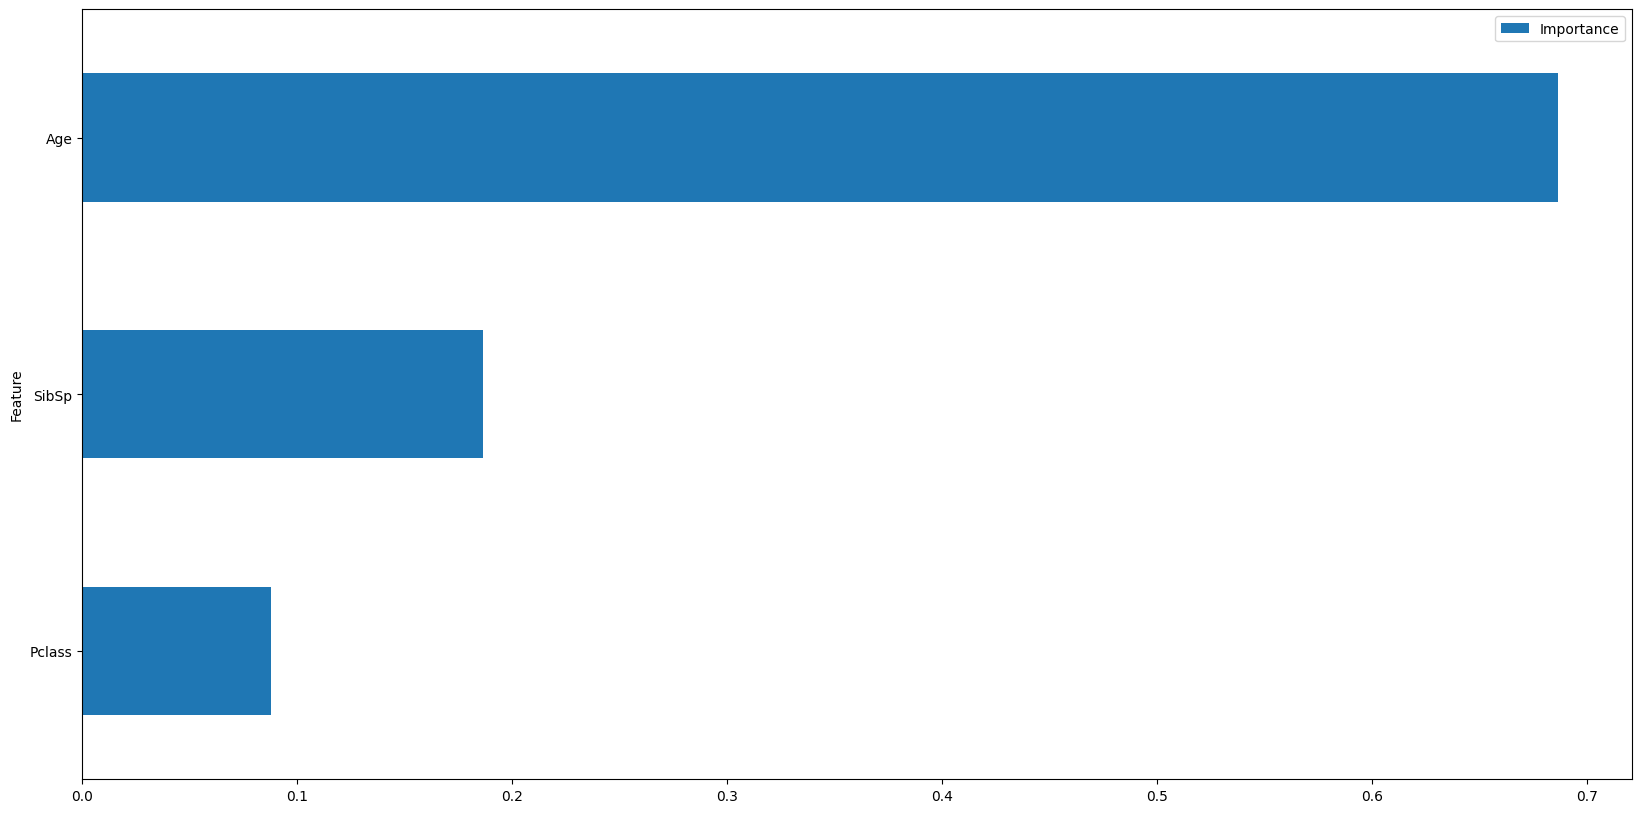

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',random_state=42,class_weight=None,max_depth=5)
dt.fit(df_num.drop('Survived',axis=1),df_num['Survived'])

plot_feature_importances(dt.feature_importances_,feature_names,top_n=3)

In [ ]:
#| export
def plot_permutation_importances(model, # sklearn tree model that has been trained
                                 X, # Training features
                                 y, # Training label
                                 scoring=['f1_macro'], # metric, or a list of metrics
                                 n_repeats=5, # Number of times to permute a feature (higher means more accurate)
                                 seed=42, # Random seed
                                 top_n=None, # Show top n features
                                 figsize=(20,10) # Matplotlib figsize
                                ):
    "Plot and return a dataframe of feature importances using sklearn.inspection.permutation_importance"
    scoring = val2list(scoring)
    r_multi = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=seed, scoring=scoring)
    fea_imp_dfs=[]
    for metric in r_multi.keys():
        print(f"{metric}")
        r = r_multi[metric]        
        fea_imp_df  = pd.DataFrame(data={'Feature':X.columns.values,'Importance':r['importances_mean'],'STD':r['importances_std']}).set_index('Feature')
        fea_imp_df = fea_imp_df.sort_values(['Importance'],ascending=True)
        if top_n is not None:
            fea_imp_df = fea_imp_df.tail(top_n)
        fig, ax = plt.subplots()
        fea_imp_df['Importance'].plot(kind='barh',figsize=figsize,xerr=fea_imp_df['STD'],ax=ax)
        ax.set_title("Feature importances using permutation")
        ax.set_ylabel("Mean metric decrease")
        fig.tight_layout()
        plt.show()
        fea_imp_dfs.append(fea_imp_df)
    return fea_imp_dfs

f1_macro


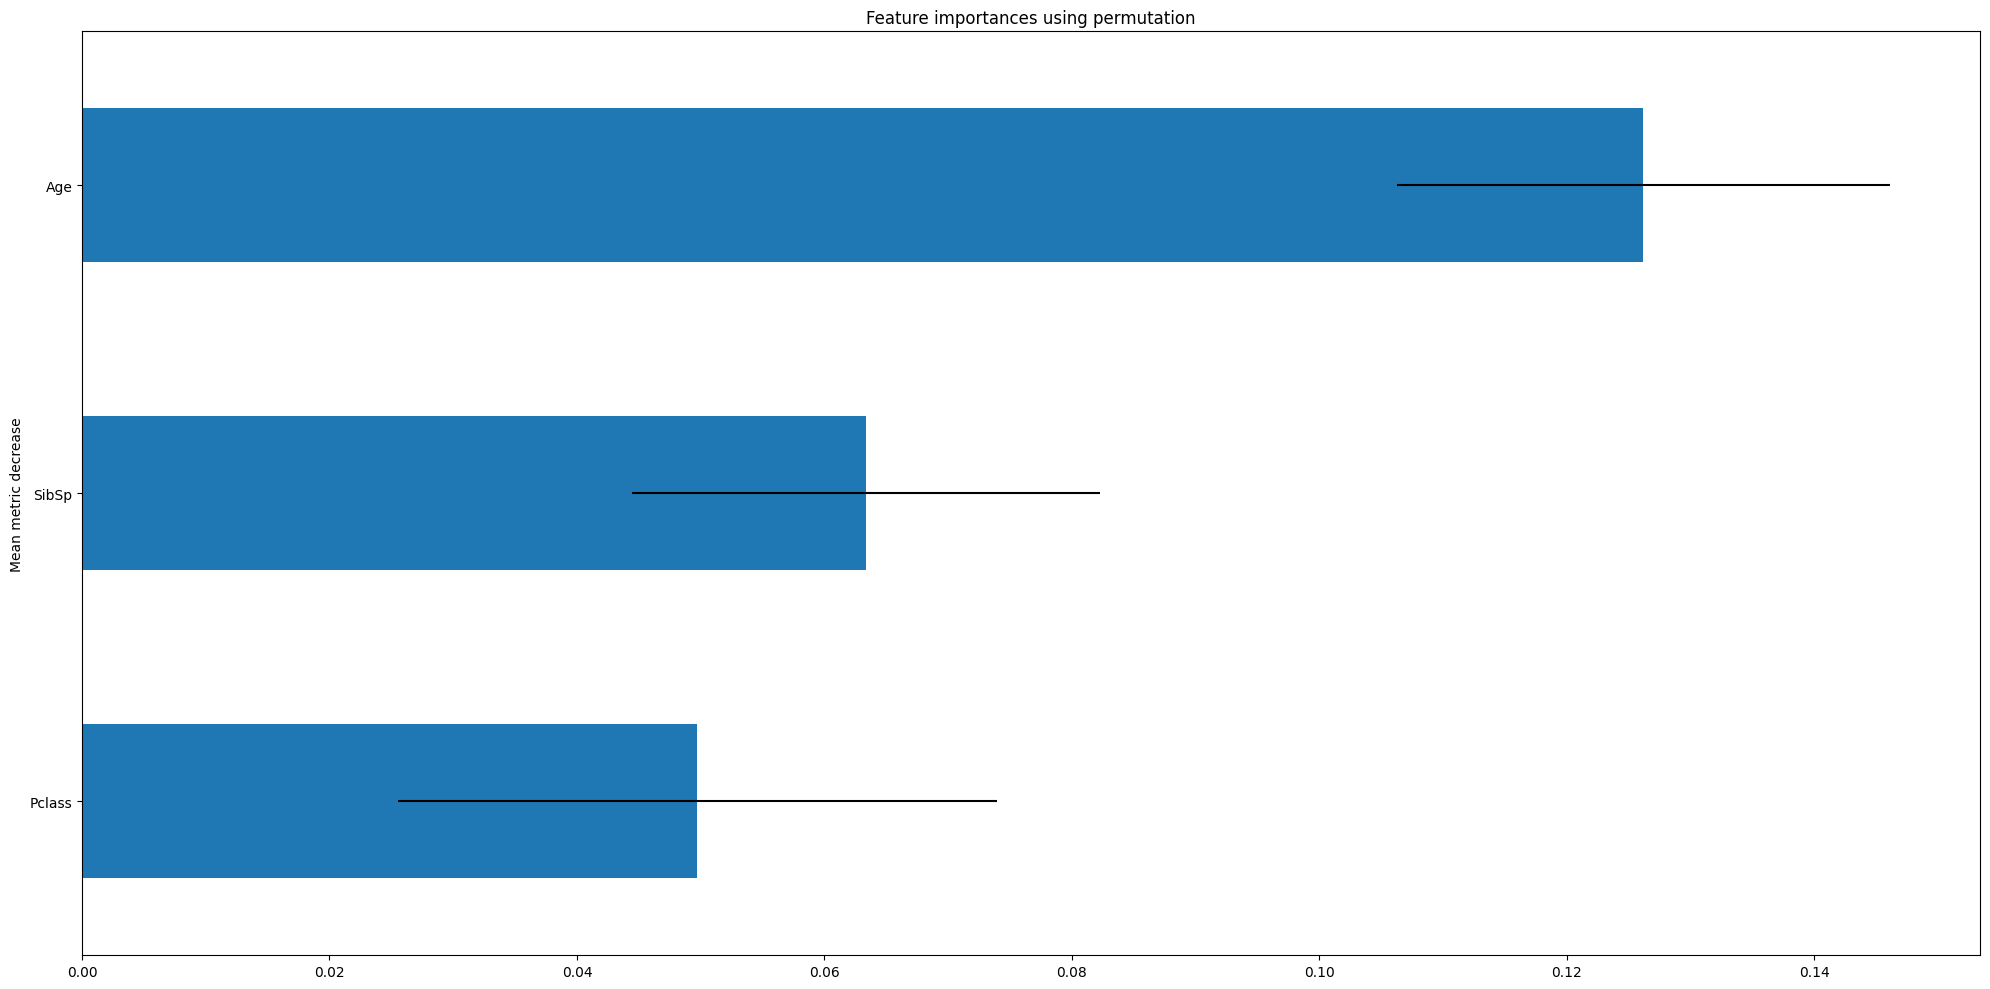

accuracy


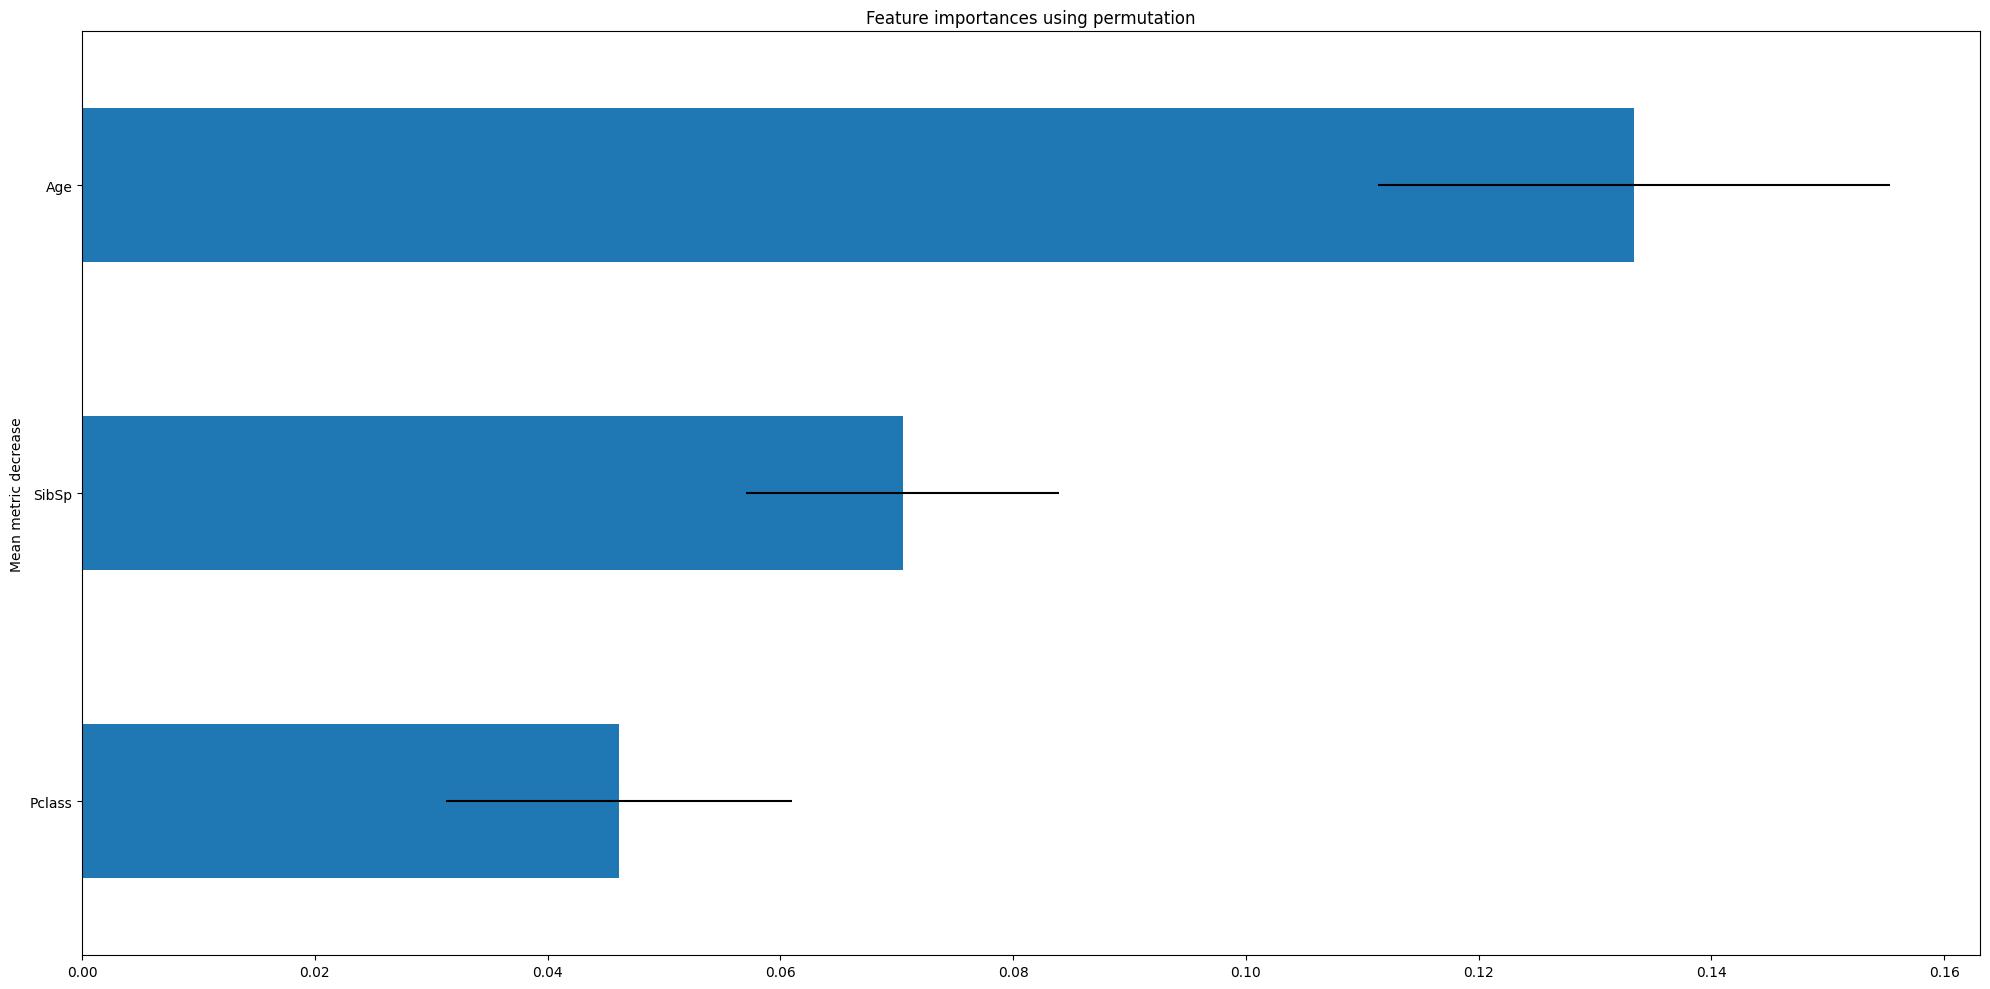

[         Importance       STD
 Feature                      
 Pclass     0.049733  0.024178
 SibSp      0.063374  0.018909
 Age        0.126187  0.019904,
          Importance       STD
 Feature                      
 Pclass     0.046154  0.014841
 SibSp      0.070513  0.013446
 Age        0.133333  0.021983]

In [ ]:
feature_names = df_num.drop('Survived',axis=1).columns.values
dt = DecisionTreeClassifier(criterion='entropy',random_state=42,class_weight=None,max_depth=5)
dt.fit(df_num.drop('Survived',axis=1),df_num['Survived'])

plot_permutation_importances(dt,
                             df_num.drop('Survived',axis=1),
                             df_num['Survived'],
                             scoring=['f1_macro','accuracy'],
                             top_n=3)

f1_macro


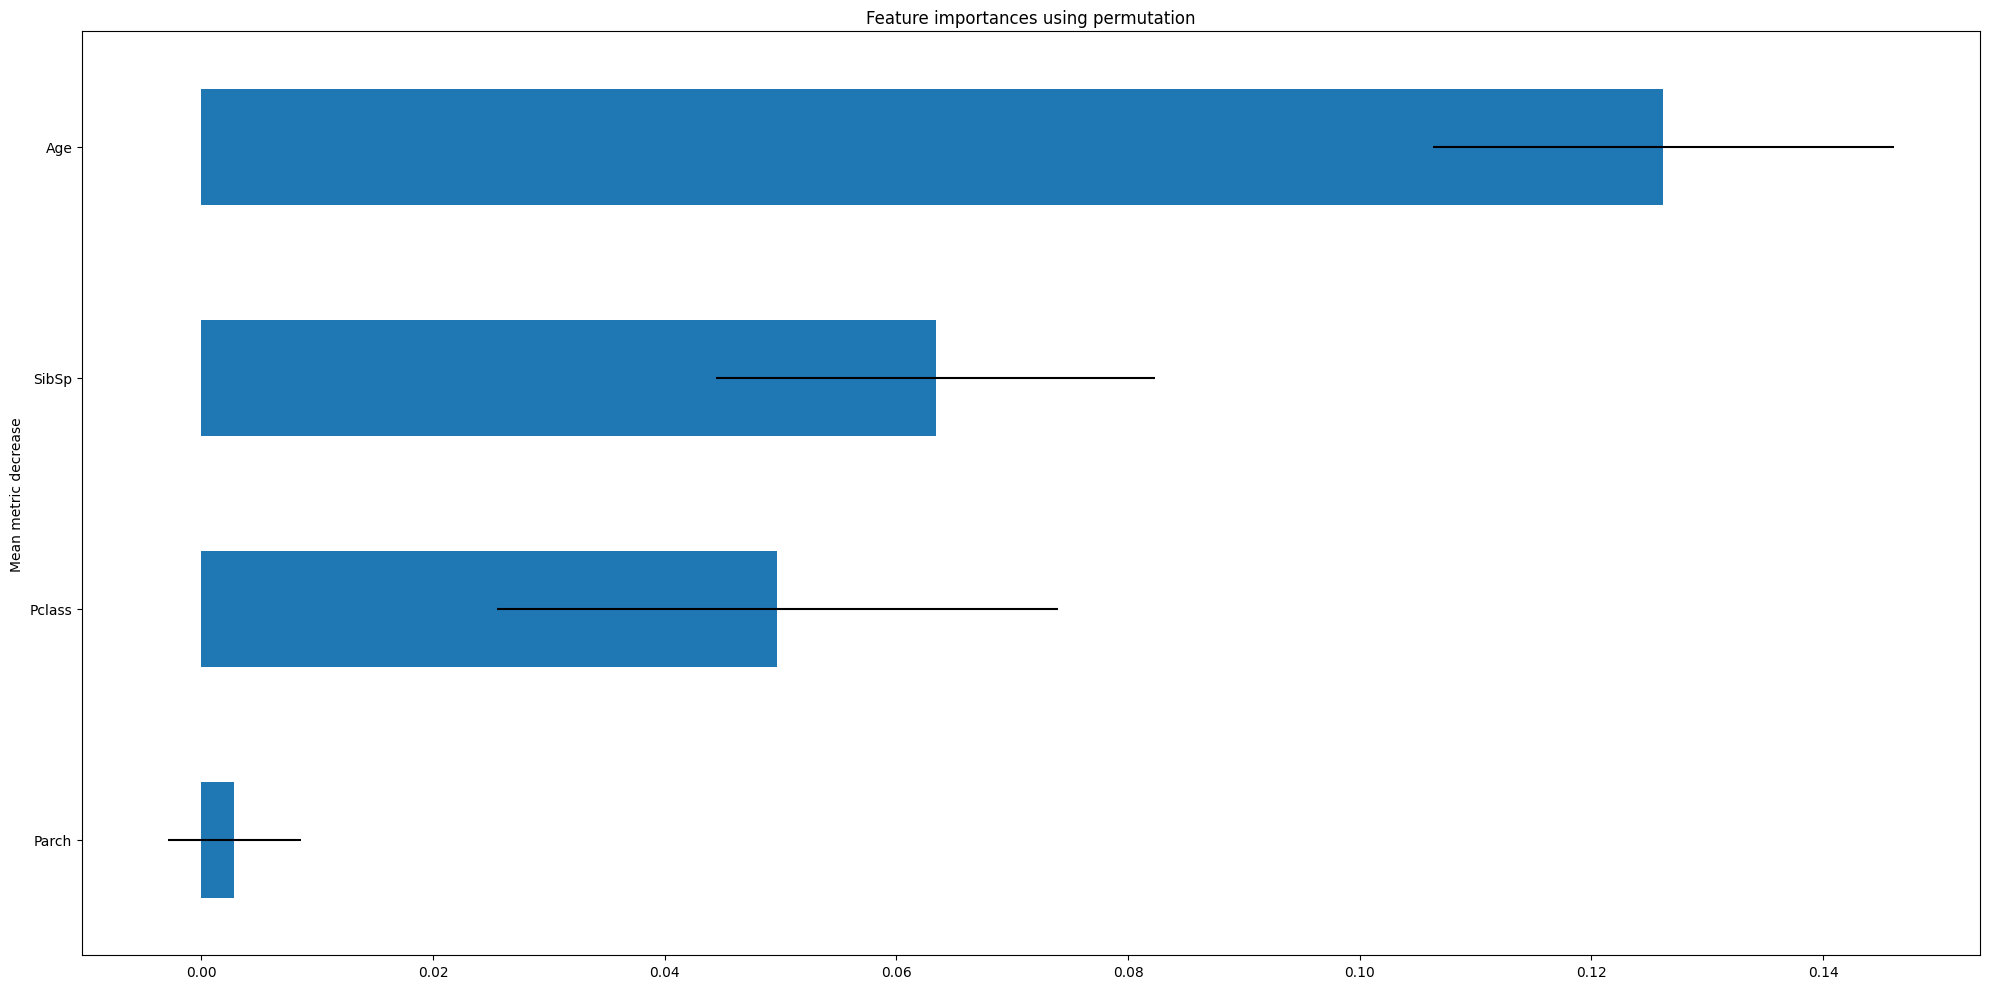

[         Importance       STD
 Feature                      
 Parch      0.002853  0.005706
 Pclass     0.049733  0.024178
 SibSp      0.063374  0.018909
 Age        0.126187  0.019904]

In [ ]:
feature_names = df_num.drop('Survived',axis=1).columns.values
dt = DecisionTreeClassifier(criterion='entropy',random_state=42,class_weight=None,max_depth=5)
dt.fit(df_num.drop('Survived',axis=1),df_num['Survived'])

plot_permutation_importances(dt,
                             df_num.drop('Survived',axis=1),
                             df_num['Survived'],
                             scoring='f1_macro'
                             )

## Hyperparameters visualization

In [ ]:
#| export
def params_2D_heatmap(search_cv:dict, # A dict with keys as column headers and values as columns. Typically an attribute (**cv_results_**) of GridSearchCV or RandomizedSearchCV
                      param1:str, # Name of the first hyperparameter
                      param2:str, # Name of the second hyperparameter
                      scoring:str='f1_macro', # Metric name 
                      log_param1=False, # To log the first hyperparameter
                      log_param2=False, # To log the second hyperparameter
                      figsize=(20,10), # Matplotlib figsize
                      min_hm=None, # Minimum value for the metric to show
                      max_hm=None, # Maximum value of the metric to show
                      higher_is_better=True): # Set if high metric is better
    "Plot 2D graph of metric value for each pair of hyperparameters"
    rs_df = pd.DataFrame(search_cv)
    cm = plt.cm.get_cmap('RdYlBu')
    z = rs_df[f'mean_test_{scoring}'].values
    if not higher_is_better:
        z*=-1
    x = rs_df[f'param_{param1}'].values
    y = rs_df[f'param_{param2}'].values
    plt.figure(figsize=figsize)
    sc = plt.scatter(x, y, c=z, vmin=z.min() if not min_hm else min_hm, vmax=z.max() if not max_hm else max_hm, s=20, cmap=cm)
    if log_param2:
        plt.yscale('log')
    if log_param1:
        plt.xscale('log')
    plt.colorbar(sc)
    plt.xlabel(param1)
    plt.ylabel(param2)
    plt.grid()
    plt.show()

In [ ]:
show_doc(params_2D_heatmap)

---

[source](https://github.com/anhquan0412/that-ml-library/blob/main/that_ml_library/chart_plotting.py#L288){target="_blank" style="float:right; font-size:smaller"}

### params_2D_heatmap

>      params_2D_heatmap (search_cv:dict, param1:str, param2:str,
>                         scoring:str='f1_macro', log_param1=False,
>                         log_param2=False, figsize=(20, 10), min_hm=None,
>                         max_hm=None, higher_is_better=True)

Plot 2D graph of metric value for each pair of hyperparameters

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| search_cv | dict |  | A dict with keys as column headers and values as columns. Typically an attribute (**cv_results_**) of GridSearchCV or RandomizedSearchCV |
| param1 | str |  | Name of the first hyperparameter |
| param2 | str |  | Name of the second hyperparameter |
| scoring | str | f1_macro | Metric name |
| log_param1 | bool | False | To log the first hyperparameter |
| log_param2 | bool | False | To log the second hyperparameter |
| figsize | tuple | (20, 10) | Matplotlib figsize |
| min_hm | NoneType | None | Minimum value for the metric to show |
| max_hm | NoneType | None | Maximum value of the metric to show |
| higher_is_better | bool | True | Set if high metric is better |

In [ ]:
dt = RandomForestClassifier(random_state=42)
param_grid={
    'n_estimators': np.arange(2,20),
    'min_samples_leaf': np.arange(1,80),
}
# Note: in order to use params_2D_heatmap, you should set scoring to a list, and set refit to False
clf = RandomizedSearchCV(dt,param_grid,n_iter=100,
                         scoring=['f1_macro'],n_jobs=-1,
                         cv=5,verbose=1,random_state=42,refit=False)
clf.fit(df_num.drop('Survived',axis=1),df_num['Survived'])


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
                                        'n_estimators': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])},
                   random_state=42, refit=False, scoring=['f1_macro'],
                   verbose=1)

/tmp/ipykernel_10974/2399879344.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


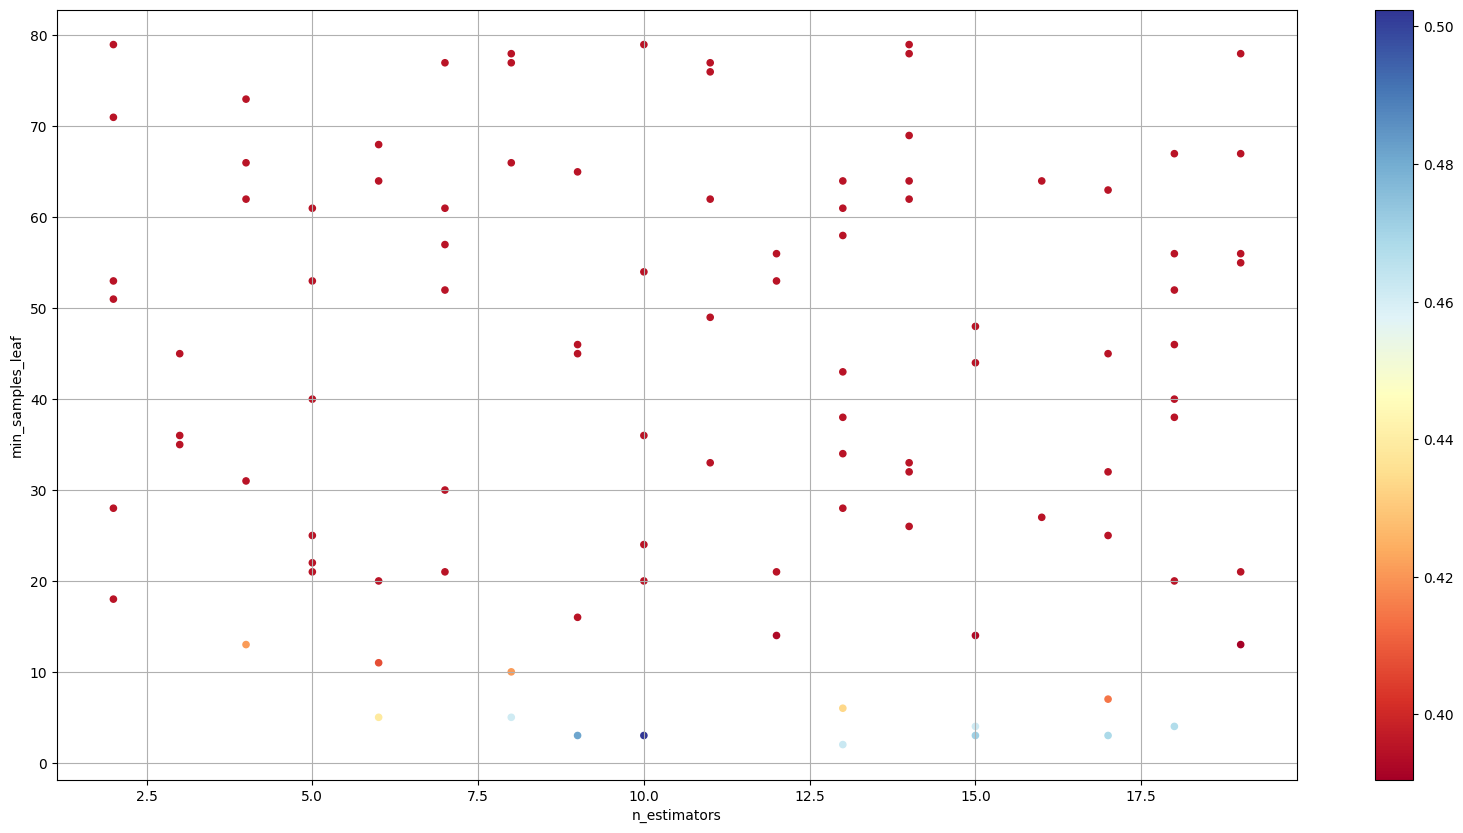

In [ ]:
params_2D_heatmap(clf.cv_results_,'n_estimators','min_samples_leaf',
                  scoring='f1_macro',
                  figsize=(20,10))

/tmp/ipykernel_10974/2399879344.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


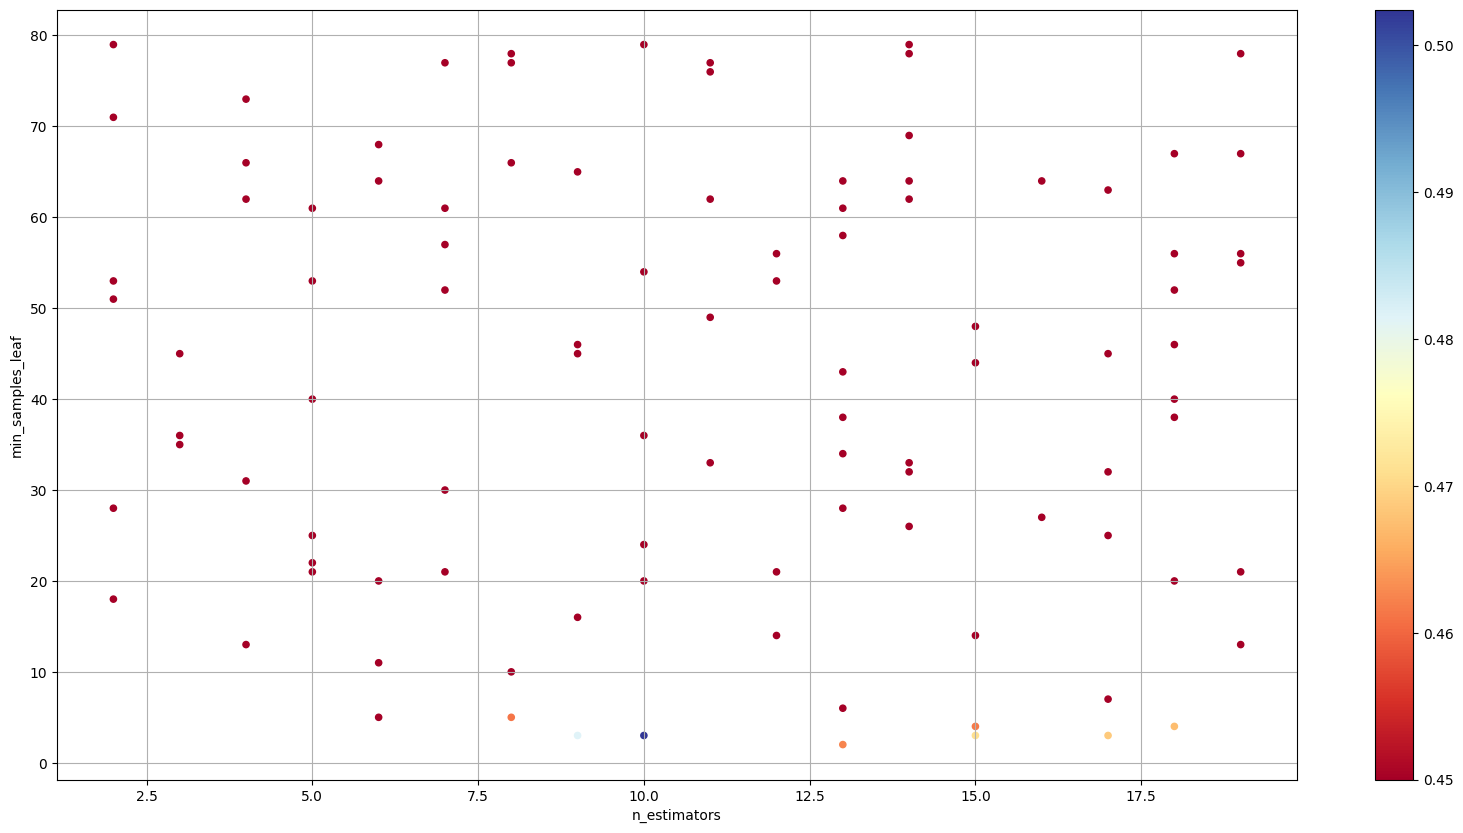

In [ ]:
params_2D_heatmap(clf.cv_results_,'n_estimators','min_samples_leaf',
                  scoring='f1_macro',
                  figsize=(20,10),min_hm=0.45)

In [ ]:
#| export
def params_3D_heatmap(search_cv:dict, # A dict with keys as column headers and values as columns. Typically an attribute (**cv_results_**) of GridSearchCV or RandomizedSearchCV
                      param1:str, # Name of the first hyperparameter
                      param2:str, # Name of the second hyperparameter
                      param3:str, # Name of the third hyperparameter
                      scoring:str='f1_macro', # Metric name 
                      log_param1=False, # To log the first hyperparameter
                      log_param2=False, # To log the second hyperparameter
                      log_param3=False # To log the third hyperparameter
                     ):
    "Plot 3D graph of metric value for each triplet of hyperparameters"
    rs_df = pd.DataFrame(search_cv)
    scores = rs_df[f'mean_test_{scoring}'].values
    fig = px.scatter_3d(rs_df, x=f'param_{param1}', y=f'param_{param2}', z=f'param_{param3}',
                    color=f'mean_test_{scoring}',range_color=[scores.min(),scores.max()],
                       log_x = log_param1, log_y=log_param2, log_z=log_param3)
    fig.show()

In [ ]:
dt = RandomForestClassifier(random_state=42)
param_grid={
    'n_estimators': np.arange(2,20),
    'min_samples_leaf': np.arange(1,80),
    'max_features': [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
}
# Note: in order to use params_2D_heatmap, you should set scoring to a list, and set refit to False
clf = RandomizedSearchCV(dt,param_grid,n_iter=100,
                         scoring=['f1_macro'],n_jobs=-1,
                         cv=5,verbose=1,random_state=42,refit=False)
clf.fit(df_num.drop('Survived',axis=1),df_num['Survived'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_features': [0.3, 0.4, 0.5, 0.6,
                                                         0.7, 0.8, 0.9, 1],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
                                        'n_estimators': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19])},
                   random_state=42, refit=False, scoring=['f1_macro'],
                   verbose=1)

In [ ]:
params_3D_heatmap(clf.cv_results_,
                  'n_estimators',
                  'min_samples_leaf',
                  'max_features',
                  scoring='f1_macro')

![](images/screenshot_plot3d.png)

## Partial Dependency Plot

In [ ]:
#| export
def pdp_numerical_only(model, # sklearn tree model that has been trained
                       df:pd.DataFrame, # dataframe of data to perform plot
                       num_features, # A list of numerical features
                       class_names:list, # List of names associated with the labels (same order); e.g. ['no','yes']
                       y_colors=None, # List of colors associated with class_names
                       ncols=2,
                       nrows=2,
                       figsize=(20,16)):
    common_params = {
    "subsample": 40,
    "n_jobs": -1,
    "grid_resolution": 100,
    "random_state": 42,
    }

    features_info = {
        # features of interest
        "features": num_features,
        # type of partial dependence plot
        "kind": "average",
        # information regarding categorical features
        "categorical_features": None,
    }

    _, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, constrained_layout=True)
    if y_colors is None:
        y_colors = get_cmap('tab10').colors

    for i in range(len(class_names)):
        _display = PartialDependenceDisplay.from_estimator(
                            model,
                            df,
                            **features_info,
                            target=i,
                            line_kw={"label": class_names[i],'color':y_colors[i]},
                            ax=ax,
                            **common_params
        )

In [ ]:
show_doc(pdp_numerical_only)

---

### pdp_numerical_only

>      pdp_numerical_only (model, df:pandas.core.frame.DataFrame, num_features,
>                          class_names:list, y_colors=None, ncols=2, nrows=2,
>                          figsize=(20, 16))

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| model |  |  | sklearn tree model that has been trained |
| df | pd.DataFrame |  | dataframe of data to perform plot |
| num_features |  |  | A list of numerical features |
| class_names | list |  | List of names associated with the labels (same order); e.g. ['no','yes'] |
| y_colors | NoneType | None | List of colors associated with class_names |
| ncols | int | 2 |  |
| nrows | int | 2 |  |
| figsize | tuple | (20, 16) |  |

In [ ]:
#| export
def pdp_categorical_only(model, # sklearn tree model that has been trained
                         df:pd.DataFrame, # dataframe of data to perform plot
                         cat_feature:list, # A list of categorical features
                         class_names:list, # List of names associated with the labels (same order); e.g. ['no','yes']
                         y_colors=None, # List of colors associated with class_names
                         ymax=0.5,
                         figsize=(20,8)):
    
    common_params = {
    "subsample": 40,
    "n_jobs": 2,
    "grid_resolution": 100,
    "random_state": 42,
    }

    features_info = {
        # features of interest
        "features": [cat_feature],
        # type of partial dependence plot
        "kind": "average",
        # information regarding categorical features
        "categorical_features": [cat_feature],
    }
    if y_colors is None:
        y_colors = get_cmap('tab10').colors

    displays=[]
    for i in range(len(class_names)): 
        _, ax = plt.subplots(figsize=(1,1))

        _display = PartialDependenceDisplay.from_estimator(
            best_model,
            df,
            **features_info,
            target=i,
            line_kw={"label": class_names[i],'color':y_colors[i]},
            ax=ax,
            **common_params,
        );
        displays.append(_display)
    
    fig, axes = plt.subplots(1, len(displays), figsize=figsize,sharey=True)
    for i in range(len(displays)):
        displays[i].plot(ax=axes[i],pdp_lim={1: (0, ymax)})
        axes[i].set_title(class_names[i])

In [ ]:
show_doc(pdp_categorical_only)

---

### pdp_categorical_only

>      pdp_categorical_only (model, df:pandas.core.frame.DataFrame,
>                            cat_feature:list, class_names:list, y_colors=None,
>                            ymax=0.5, figsize=(20, 8))

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| model |  |  | sklearn tree model that has been trained |
| df | pd.DataFrame |  | dataframe of data to perform plot |
| cat_feature | list |  | A list of categorical features |
| class_names | list |  | List of names associated with the labels (same order); e.g. ['no','yes'] |
| y_colors | NoneType | None | List of colors associated with class_names |
| ymax | float | 0.5 |  |
| figsize | tuple | (20, 8) |  |

In [ ]:
#| export
def plot_ice_pair(model, # sklearn tree model that has been trained
                  df:pd.DataFrame, # dataframe of data to perform plot
                  pair_features:list, # a list of only 2 features
                  class_idx, # index of the class to plot
                  figsize=(10,4)):
    common_params = {
        "subsample": 40,
        "n_jobs": -1,
        "grid_resolution": 100,
        "random_state": 42,
    }
    fea_to_plot = pair_features
    features_info = {
        # features of interest
        "features": [fea_to_plot[0],fea_to_plot[1], fea_to_plot],
        # type of partial dependence plot
        "kind": "average",
        # information regarding categorical features
        "categorical_features": None,
    }

    _, ax = plt.subplots(ncols=3, figsize=figsize, constrained_layout=True)

    _display = PartialDependenceDisplay.from_estimator(
        best_model,
        df,
        **features_info,
        target=class_idx,
        ax=ax,
        **common_params,
    )
    plt.setp(_display.deciles_vlines_, visible=False)

In [ ]:
show_doc(plot_ice_pair)

---

### plot_ice_pair

>      plot_ice_pair (model, df:pandas.core.frame.DataFrame, pair_features:list,
>                     class_idx, figsize=(10, 4))

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| model |  |  | sklearn tree model that has been trained |
| df | pd.DataFrame |  | dataframe of data to perform plot |
| pair_features | list |  | a list of only 2 features |
| class_idx |  |  | index of the class to plot |
| figsize | tuple | (10, 4) |  |

## Other functions

In [ ]:
#| export
def plot_confusion_matrix(y_true, # A list/numpy array of true labels 
                          y_pred, # A list/numpy array of predictions
                          labels=None # Display names matching the labels (same order).
                         ):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp.plot()
    plt.show()

In [ ]:
#| export
def draw_sankey(data, target,chart_name,save_name=None):
    PATH = Path('sk_reports')
    unique_source_target = list(pd.unique(data[['source', 'target']].values.ravel('K')))
    mapping_dict = {k: v for v, k in enumerate(unique_source_target)}
    data = data.copy()
    data['source'] = data['source'].map(mapping_dict)
    data['target'] = data['target'].map(mapping_dict)
    links_dict = data.to_dict(orient='list')

    nodes = np.unique(data[["source", "target"]], axis=None)
    nodes = pd.Series(index=nodes, data=range(len(nodes)))


    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = unique_source_target,
          # color = [px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] for i in nodes.loc[data["source"]]]
        ),
        link = dict(
          source = links_dict["source"],
          target = links_dict["target"],
          value = links_dict[target],
          color = [px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)] for i in nodes.loc[data["source"]]],
      ))])
    fig.update_layout(title_text=chart_name, font_size=10)
    fig.show()
    if save_name: fig.write_html(str(PATH/save_name)+ '.html')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()